In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
# from bo_methods_lib.bo_methods_lib.bo_functions_generic import gen_theta_set, clean_1D_arrays
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#From signac
import signac
date_time_str = None
meth_name_str_list = [1,2,3,4,5]
study_id = "ep"
save_csv = True


criteria_dict = {"cs_name_val" : 2,
                 "param_name_str" : "A",
                 "retrain_GP": 5,
                 "num_x_data": 5,
                 "num_val_pts": 0}

df = pd.DataFrame()
job_list = []
for meth_name_val in meth_name_str_list:
    criteria_dict["meth_name_val"] = meth_name_val
    df_piece, jobs, name_cs_str, theta_true = get_study_data_signac(criteria_dict, study_id, save_csv)
    job_list += [job for job in jobs]
#     df_best = get_best_data(df_piece, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
    df = pd.concat([df, df_piece], ignore_index=True)
    
# df = df[df['EP Method Val'] == 4]

In [4]:
### Get Best Data from ep experiment
save_csv = True
df_best = get_best_data(df, study_id, name_cs_str, theta_true, job_list, date_time_str, save_csv)
df_best

# save_path = "Results/" + study_id + "_study/" + cs_name + "/" + param_name_str + "/" +  study_id + "_study_best.csv"
# df_best.to_csv(save_path, header = True)
# #Get Mean Data from ep experiment
# df_mean = get_mean_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_mean

# #Get Median Data from ep experiment
# df_median = get_median_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)

# #Get Median of Best Data from ep experiment
# df_median_best = get_median_data(df_best, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_median_best

,Run Number,BO Iter,Best Error,Exploration Bias,Max EI,Theta Max EI,Min Obj,Min Obj Act,Theta Min Obj,Min Obj Cum.,Theta Min Obj Cum.,Time/Iter,EP Method Val,BO Method,Max Evals,Total Run Time,L2 Norm Theta
3,1,1,10032.584917,1.0,0.0,"[-289.2761348714354, -24.306417480888342, -202...",706.542848,23824.494556,"[-300.0, -200.0, -195.93529315544188, 15.02812...",23824.494556,"[-300.0, -200.0, -195.93529315544188, 15.02812...",0.606664,1,A1,2,1.213328,143.779832
43,6,1,9.213594,1.0,0.0,"[-289.2761348714354, -24.306417480888342, -202...",8.639559,10.29164,"[-300.0, -200.0, -250.0, 15.184485181125462]",10.29164,"[-300.0, -200.0, -250.0, 15.184485181125462]",0.434646,1,B1,2,0.869291,162.480873
149,12,5,0.150423,1.0,0.0,"[-153.26933005534198, -107.15613374388703, -21...",0.002823,0.04728,"[-199.96789267909264, -99.98424256551019, -169...",0.04728,"[-199.96789267909264, -99.98424256551019, -169...",132.66504,1,A2,7,928.65528,0.038476
857,14,57,9.213594,1.0,230.339839,"[-167.6281476158113, -15.745240116853552, -224...",0.541613,3.849549,"[-198.31737222062446, -101.02951824426954, -16...",3.849549,"[-198.31737222062446, -101.02951824426954, -16...",773.405338,1,B2,59,45630.914945,2.140043
872,6,1,10032.584917,1.0,0.0,"[-194.15637417332232, -170.31358961285383, -19...",0.002263,88.795619,"[-198.56501099291387, -100.64230261600161, -16...",88.795619,"[-198.56501099291387, -100.64230261600161, -16...",74.311701,1,C2,2,148.623401,1.946621


In [5]:
#Get only the jobs which are the best
project = signac.get_project()
job_list_best = []
for meth_name_val in meth_name_str_list:
    #Get best ep data from previous results if possible    
    criteria_dict_ep = criteria_dict.copy()
    criteria_dict_ep["meth_name_val"] = meth_name_val
    criteria_dict_ep["sep_fact"] = 1.0
    meth_name = Method_name_enum(meth_name_val).name
    
    path_name = job_list[0].fn(study_id + "_study_best_all.csv")
    df_ep_best = pd.read_csv(path_name, header = 0)
    best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
    criteria_dict_ep["ep_enum_val"] = best_ep_enum_val
    
    #Get all jobs with that ep enum val
    jobs_best = project.find_jobs(criteria_dict_ep)
    job_list_best += [job for job in jobs_best]

for i in range(len(job_list_best)): 
    print(job_list_best[i].id)

175ca6f32566849d634b8692641db928
723261ea32cb47fcfbd4e909020bde46
a6a9ee856ea1959290b9fdaa973875a5
bcf2d4b0feb28fa873126f3511bcd28d
4887c9289cdb36e51a368141018537e4


In [11]:
title_fontsize = 24
other_fontsize = 20
xbins = 4
ybins = 5
zbins = 900
save_path = None
cmap = "autumn"
pair = 0
log_data = True

title = "Heat Map Pair "
z_choice = "sse_mean"
title = "Heat Map Pair " + z_choice
title = None
levels = [100,100,100, 100, 100]
run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
bo_iter_list = list(map(int, df_best["BO Iter"].to_numpy() + 1))

meth_name_str_list = ["A1", "B1", "A2", "B2", "C2"]

pair = 0

file_path_list = [job.fn("BO_Results.gz") for job in job_list_best]

compare_method_heat_maps(file_path_list, meth_name_str_list, run_num_list, bo_iter_list, pair, 
                         z_choice, log_data, levels, xbins, ybins, zbins, title, title_fontsize, other_fontsize, 
                         cmap, save_path)

Method:  A1
Run Number:  2
BO Iter Number:  2
Trained Hyperparameters:  [array([749.42804834, 434.00178794, 222.51459163,   2.33458513]), 0.0001, 1]


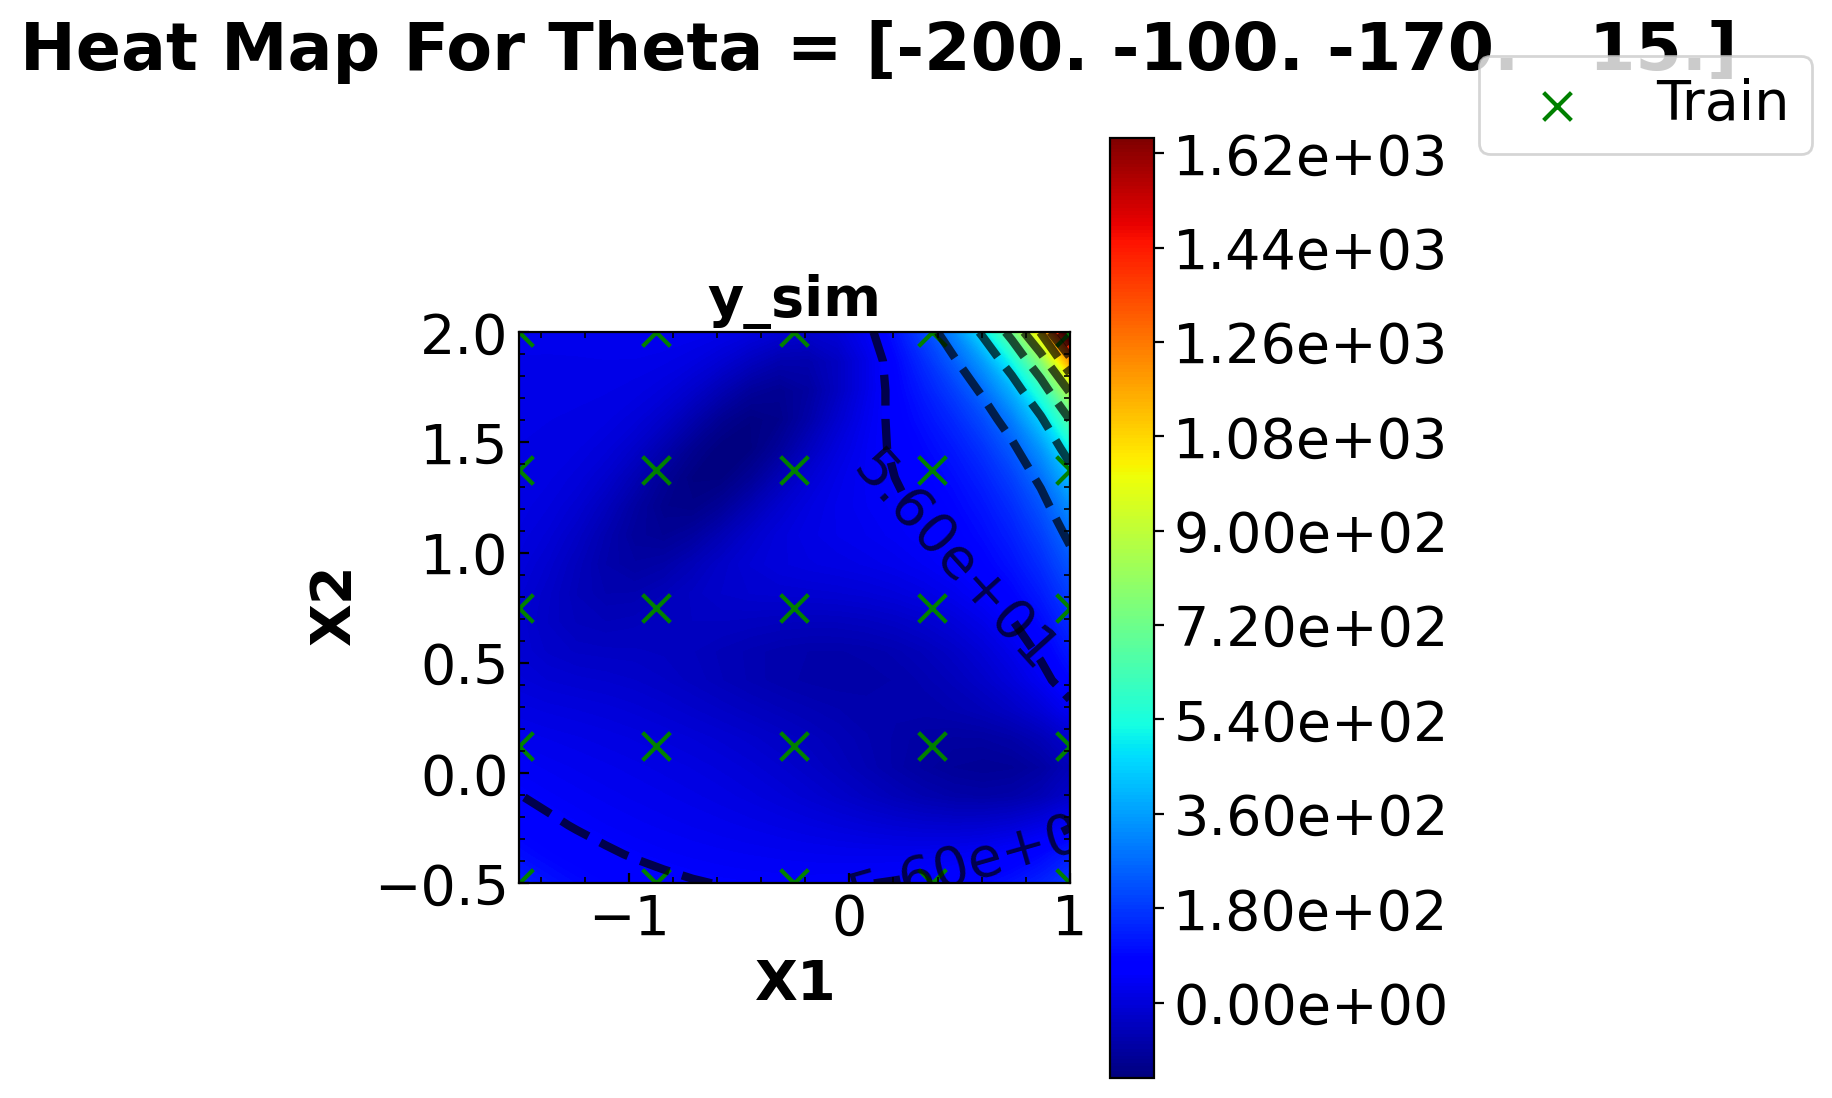

Method:  B1
Run Number:  7
BO Iter Number:  2
Trained Hyperparameters:  [array([1506.24134496,  679.32737079,  404.80344635,    3.69395473]), 0.0001, 1]


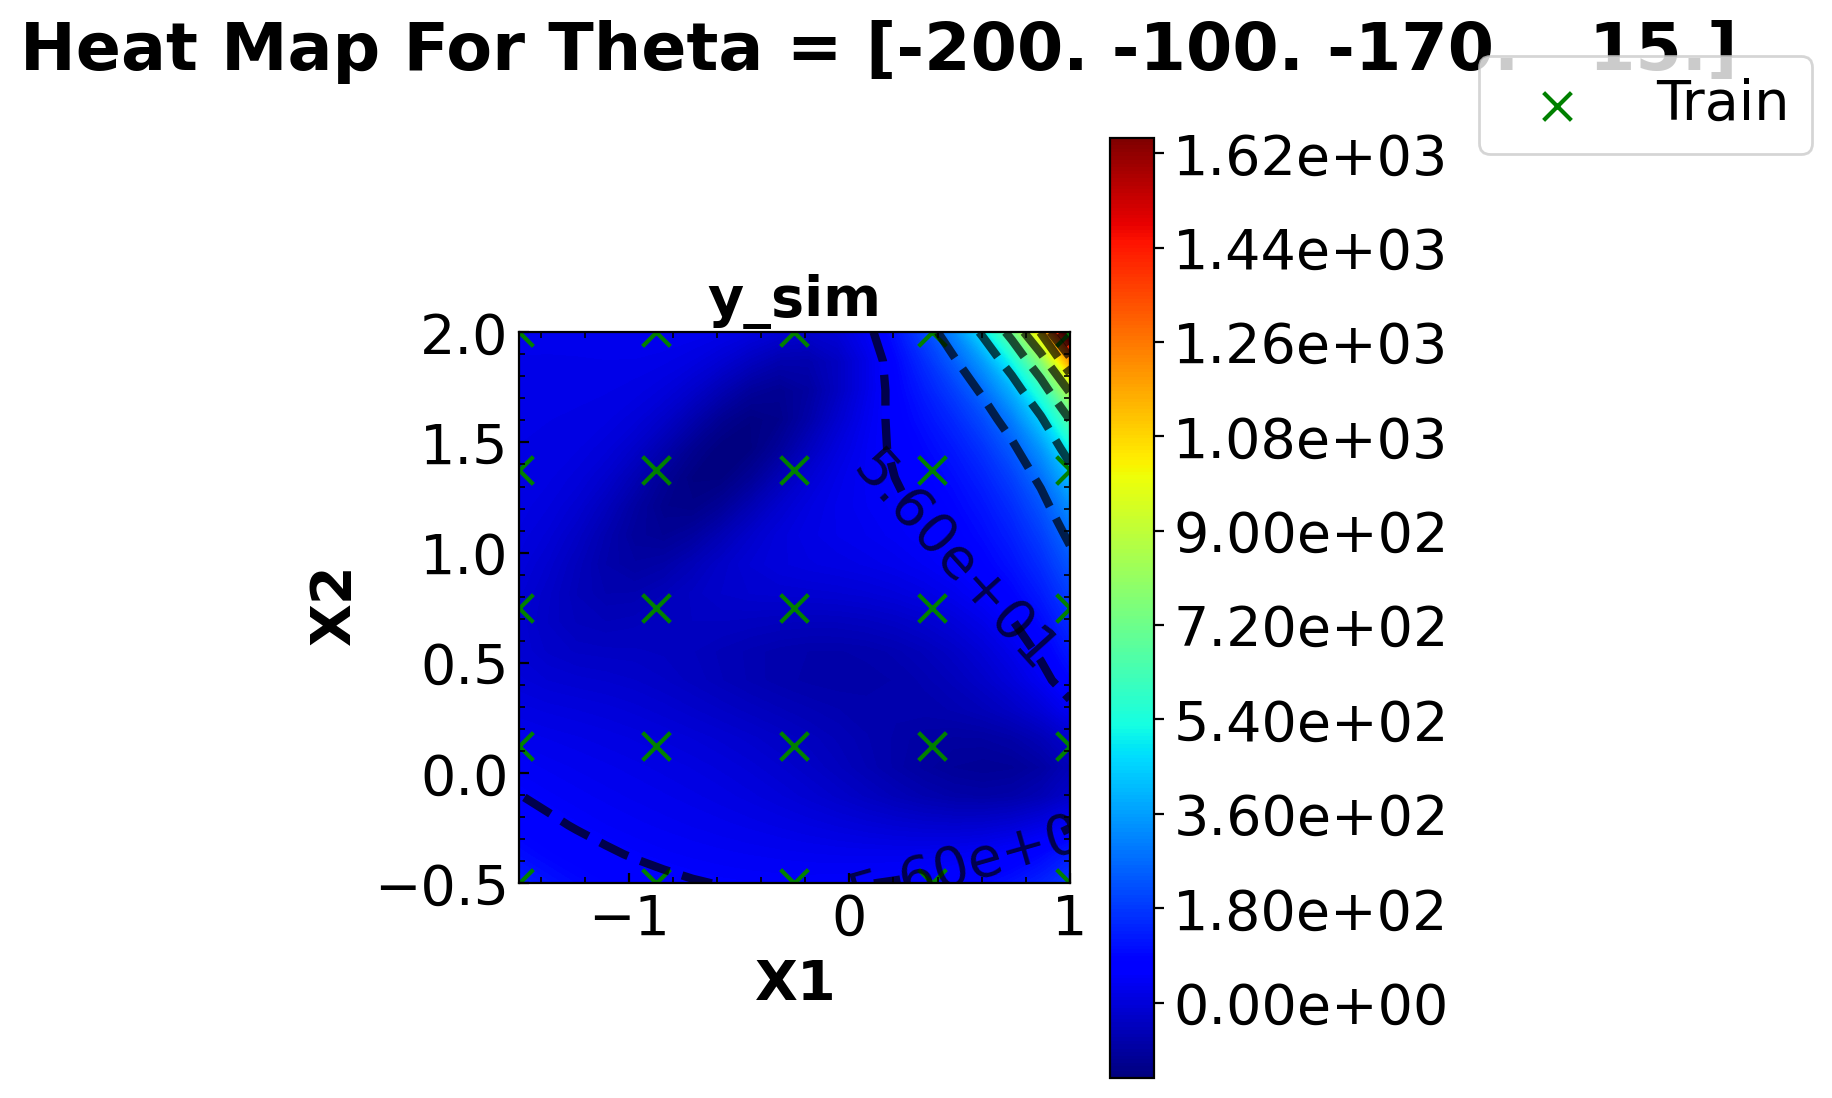

Method:  A2
Run Number:  13
BO Iter Number:  6
Trained Hyperparameters:  [array([4.74487769e+02, 5.98311468e+02, 4.95447312e+02, 7.59902786e+00,
       3.30481272e-01, 3.64396850e-01]), 0.0001, 1]


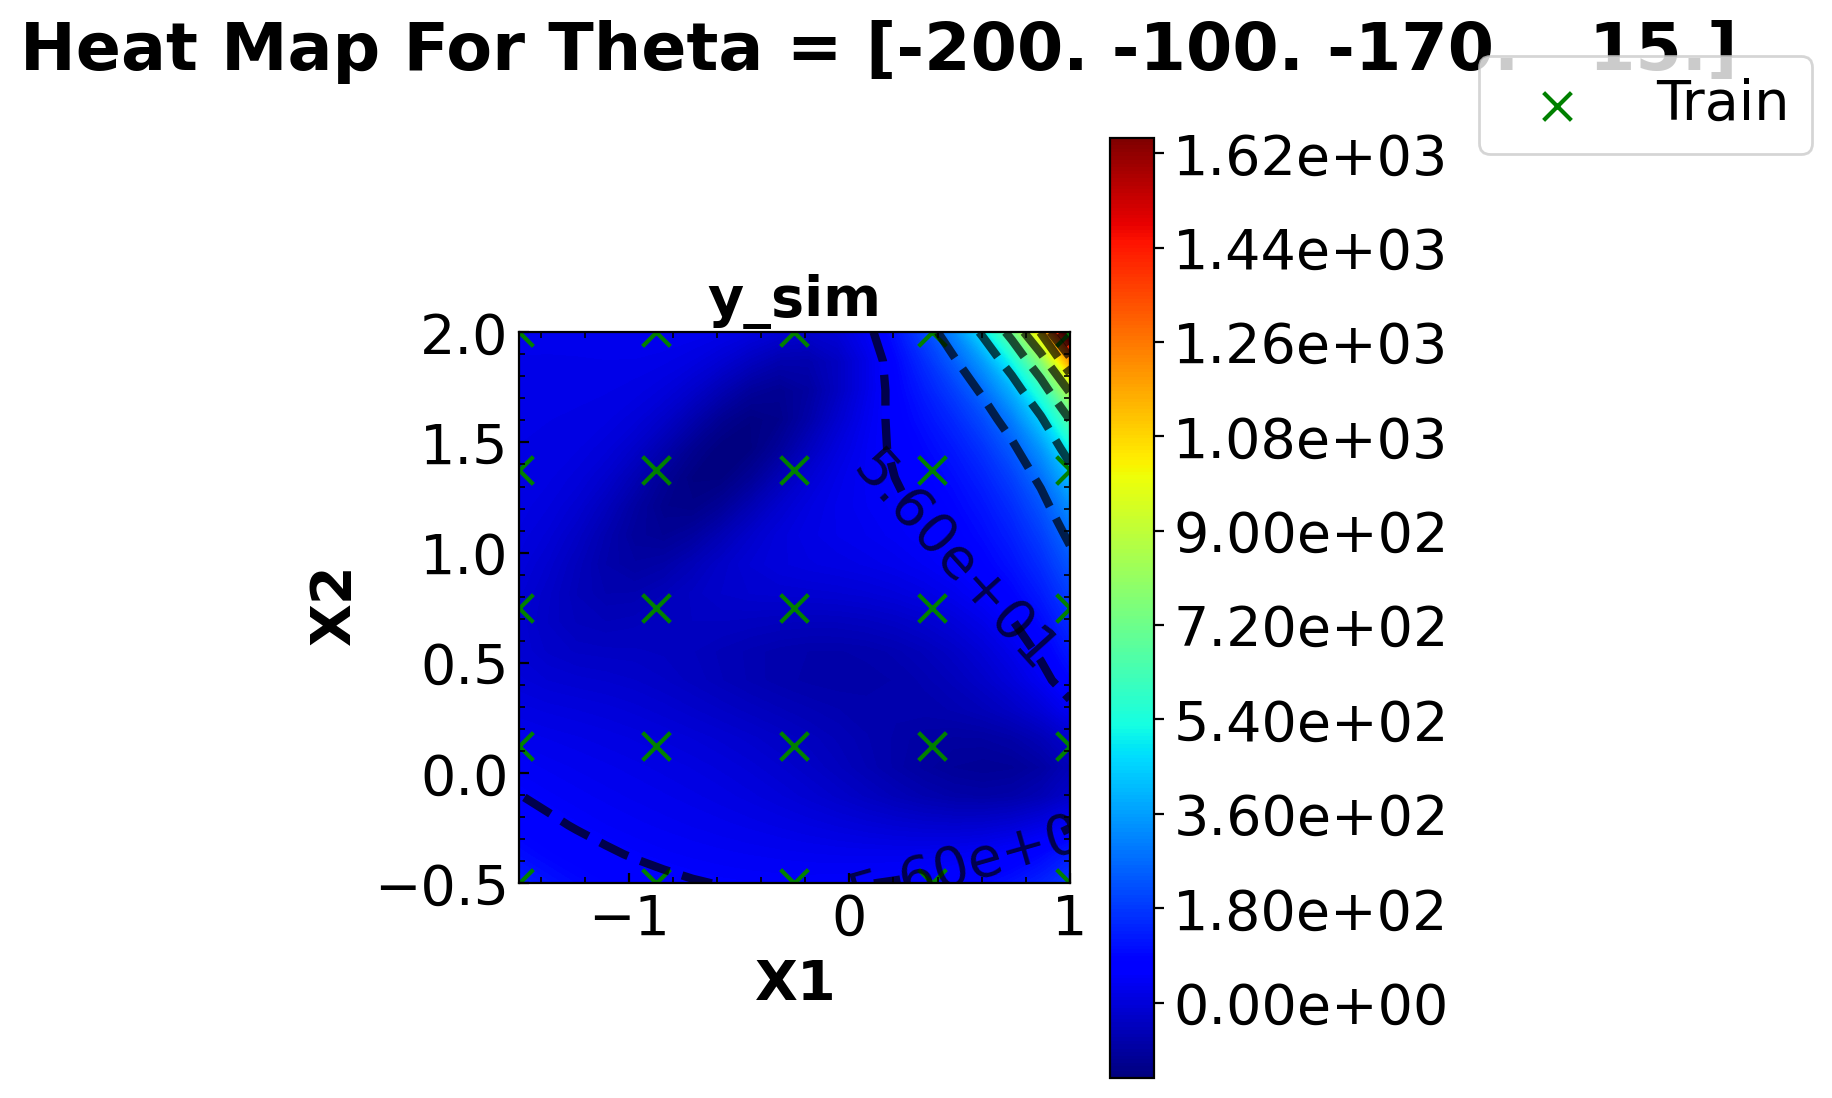

Method:  B2
Run Number:  15
BO Iter Number:  58
Trained Hyperparameters:  [array([4.87171177e+02, 5.50121891e+02, 4.69038566e+02, 7.04259884e+00,
       1.00000000e-05, 3.64102545e-01]), 0.0001, 1]


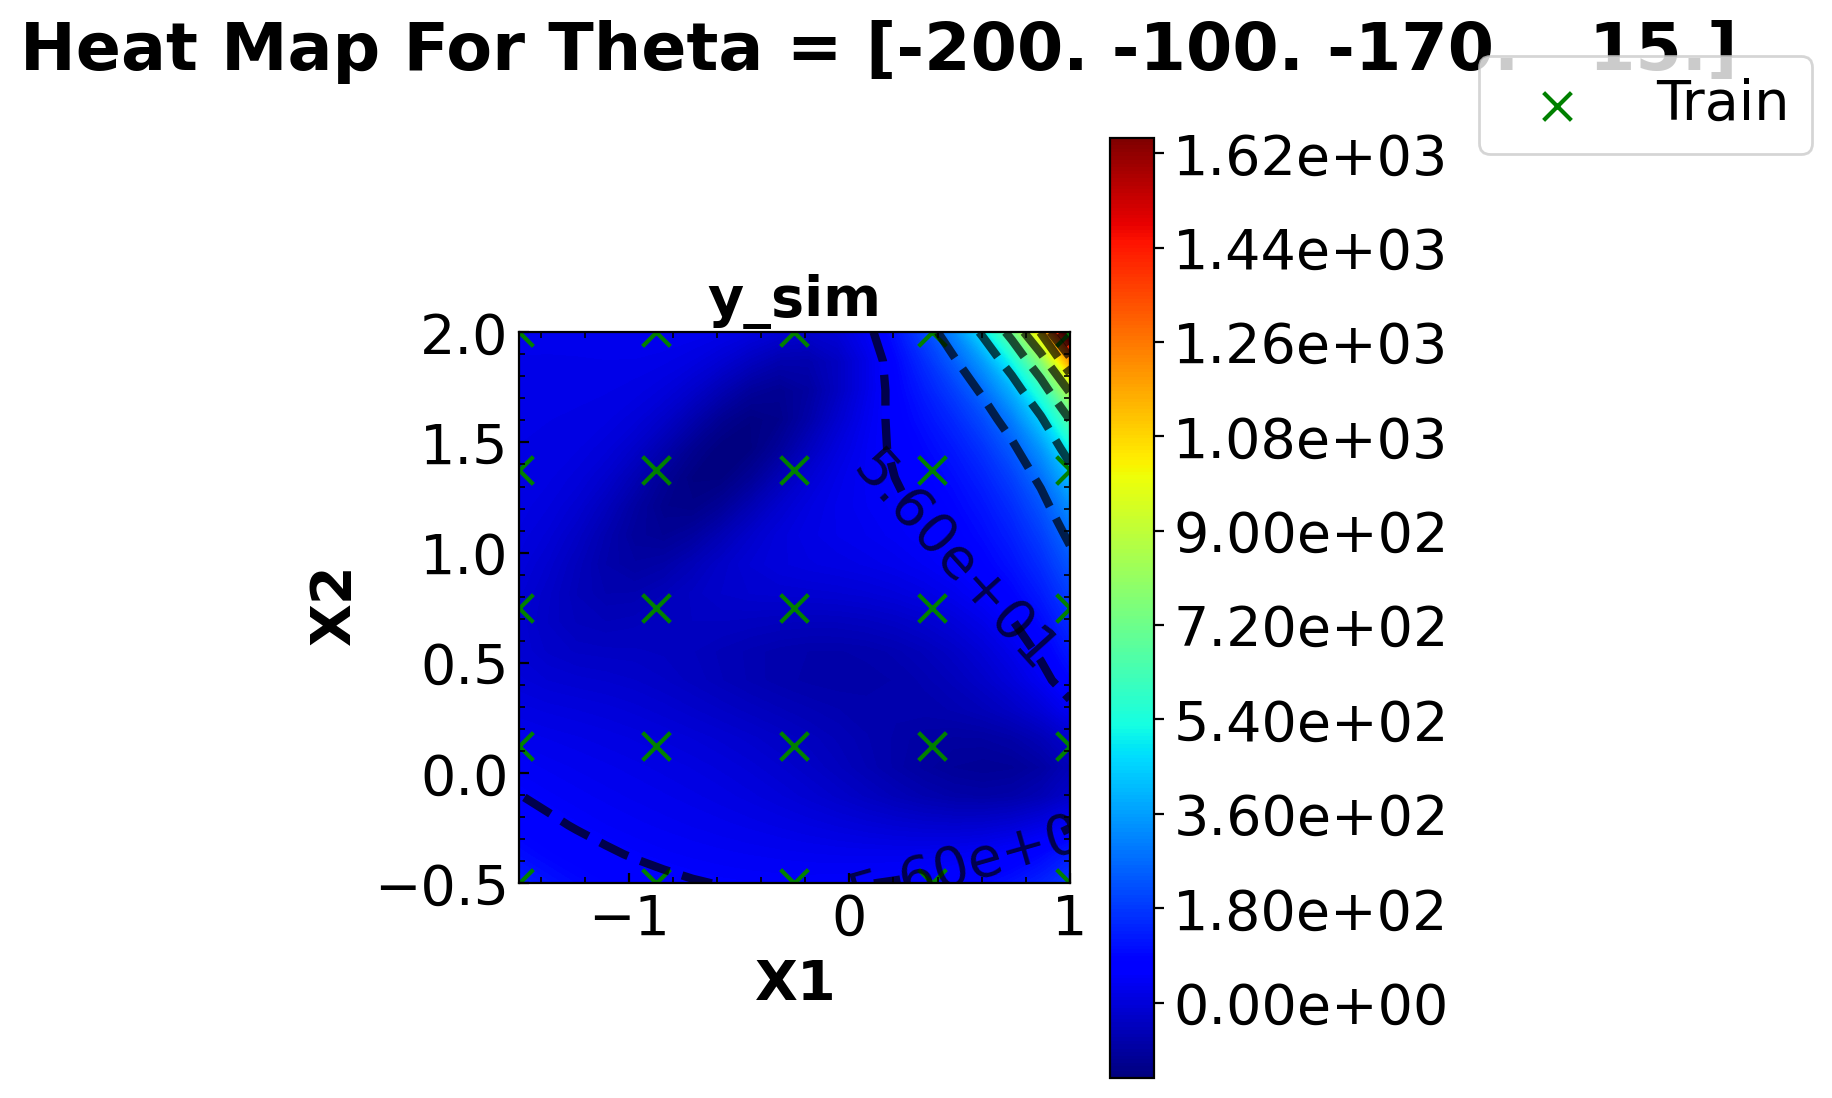

Method:  C2
Run Number:  7
BO Iter Number:  2
Trained Hyperparameters:  [array([5.07035272e+02, 5.73472131e+02, 4.74708234e+02, 7.21937604e+00,
       2.24060469e-05, 9.64927556e-03]), 0.0001, 1]


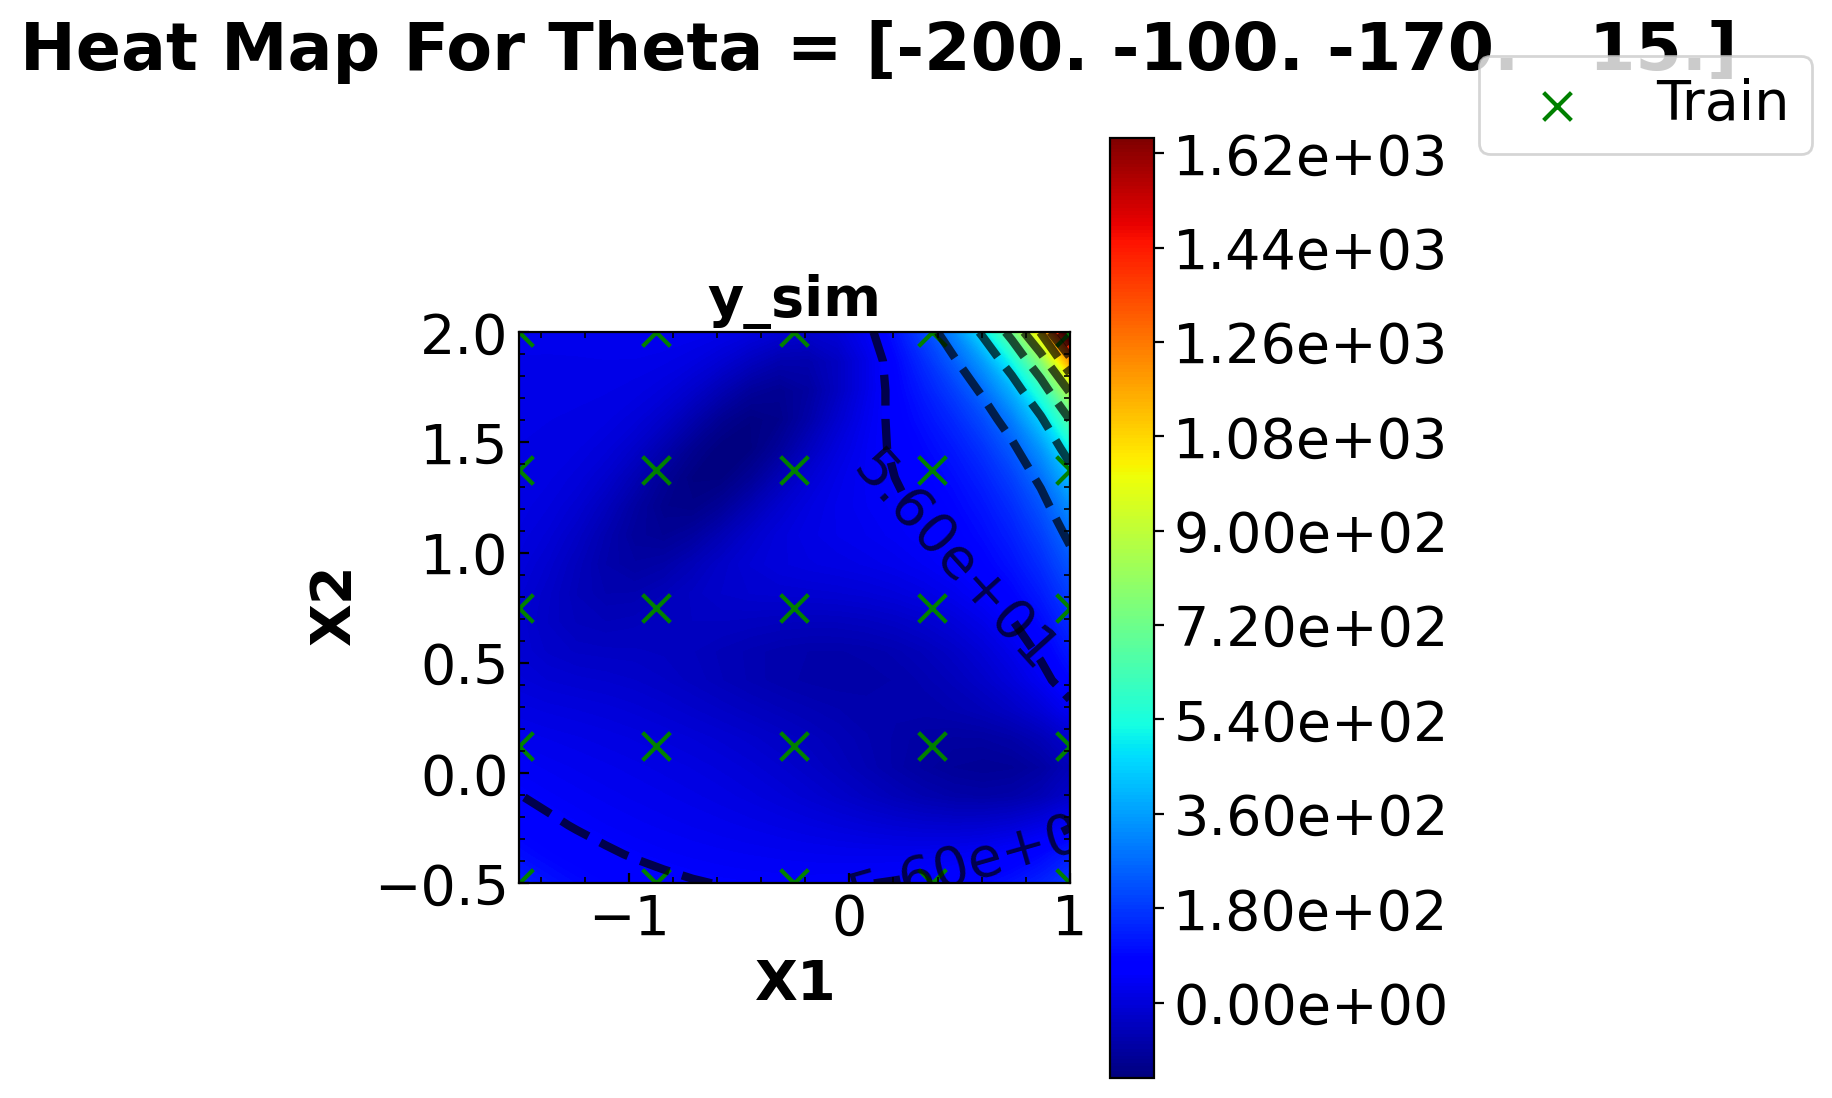

In [7]:
#Plot Muller potential
project = signac.get_project()
for meth_val in meth_name_str_list:
    criteria_dict["meth_name_val"] = meth_val
    jobs = project.find_jobs(criteria_dict) 
    for job in jobs:
        file_path = job.fn("BO_Results.gz")

    loaded_results = open_file_helper(file_path)
    meth_name = Method_name_enum(loaded_results[0].configuration["Method Name Enum Value"]).name


    run_num = df_best.loc[df_best['BO Method'].str.contains(meth_name), 'Run Number'].iloc[0] + 1
    bo_iter = df_best.loc[df_best['BO Method'].str.contains(meth_name), 'BO Iter'].iloc[0] + 1
    trained_hps = loaded_results[run_num-1].list_gp_emulator_class[bo_iter-1].trained_hyperparams
    print("Method: ", meth_name)
    print("Run Number: ", run_num)
    print("BO Iter Number: ", bo_iter)
    print("Trained Hyperparameters: ", trained_hps)
    x_val_num = 20
    theta_choice = None
    theta_true = loaded_results[run_num-1].simulator_class.theta_true
    theta_choice = theta_true
    seed = loaded_results[0].configuration["Seed"]

    title_fontsize = 24
    other_fontsize = 20
    xbins = 4
    ybins = 5
    zbins = 900
    save_path = None
    cmap = "autumn"
    save_path = None

    data_vals = compare_muller_heat_map(file_path, run_num, bo_iter, x_val_num, theta_choice, seed)
    test_mesh, y_sim, gp_mean, gp_var, theta_value, train_X, idcs_to_plot = data_vals
    title = "Heat Map For Theta = " + str(np.round(theta_value,1))

    z = [y_sim]
#     z_titles = ["y_sim"]
    cmap = "jet"
    levels = [100,100,100]
    plot_axis_names = ["X1", "X2"]

    plot_heat_maps(test_mesh, None, None, None, train_X, plot_axis_names, levels, idcs_to_plot, z, 
                   z_titles, xbins, ybins, zbins, title, title_fontsize, other_fontsize, cmap, save_path)